In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

# for plots and aniamtions
import matplotlib.pyplot as plt
#plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.figsize"] = (5,5)
import matplotlib.animation as animation
from IPython.display import HTML

# for the computation
import torch as th
th.manual_seed(1234)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch_dpmm.models import GaussianDPMM
import numpy as np
from tqdm import tqdm

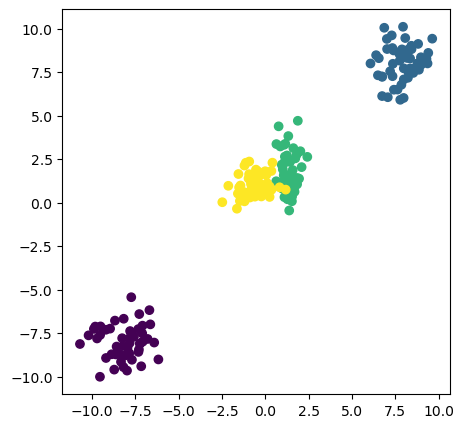

In [2]:
# create the data
num_classes = 4
D = 2

a = th.randn(D,D)
b = th.randn(D,D)

x = th.cat((MultivariateNormal(-8 * th.ones(D), th.eye(D)).sample([50]),
            MultivariateNormal(8 * th.ones(D), th.eye(D)).sample([50]),
            MultivariateNormal(th.tensor([1.5, 2]), a @ a.T).sample([50]),
            MultivariateNormal(th.tensor([-0.5, 1]), b@b.T).sample([50])))

y = th.cat((0*th.ones(50),
            1*th.ones(50),
            2*th.ones(50),
            3*th.ones(50))).to(th.int64)

#x = (x-th.mean(x, dim=0, keepdim=True)) / th.std(x, dim=0, keepdim=True)
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

## Train a Gaussina DPMM

In [3]:
# define the model
from plot_utils import plot_Gauss2D_contour
K = 20
D = 2

my_DPMM_full = GaussianDPMM(K=K, D=D, alphaDP=10, tau0=0, c0=1, n0=3*D, B0=1, is_diagonal=False, is_B0_diagonal=True)
my_DPMM_diag = GaussianDPMM(K=K, D=D, alphaDP=10, tau0=0, c0=1, n0=3*D, B0=1, is_diagonal=True, is_B0_diagonal=True)

def train_DPMM(m, title=None):
    lr = 0.8 # 0.01
    optimiser = optim.SGD(params=m.parameters(), lr=lr)

    # for the animation
    plt.ioff()
    fig, ax = plt.subplots()
    if title is not None:
        ax.set_title(title)
        
    lines_to_plot = []

    num_iterations = 50
    pbar = tqdm(range(num_iterations))
    elbo_losses = []
    for j in pbar:
        optimiser.zero_grad()
        pi, elbo_loss = m(x)
        elbo_loss.backward()
        optimiser.step()
        elbo_losses.append(elbo_loss.detach().item())

        pbar.set_postfix({'ELBO loss': elbo_loss.detach().item()})

        if j % 1 ==0:
            x_np = x.detach().numpy()
            to_plot = [ax.scatter(x_np[:, 0], x_np[:, 1], c=y.numpy(),animated=True)]
            pi, mu, Sigma = m.get_expected_params()
            pi, mu, Sigma = pi.numpy(), mu.numpy(), Sigma.numpy()
            for k in range(K):
                if pi[k]>0.05:
                    to_plot += (plot_Gauss2D_contour(mu[k], Sigma[k], ax=ax, animated=True))

            lines_to_plot.append(to_plot)
    anim = animation.ArtistAnimation(fig, lines_to_plot, repeat=True, interval=100, blit=True)
    plt.ion();
    plt.close();
    return m, anim, elbo_losses

my_DPMM_diag, anim_diag, elbo_diag = train_DPMM(my_DPMM_diag, 'Diagonal DPMM')
my_DPMM_full, anim_full, elbo_full = train_DPMM(my_DPMM_full, 'Full DPMM')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 65.58it/s, ELBO loss=2.29]


In [4]:
HTML(anim_diag.to_html5_video())

In [5]:
HTML(anim_full.to_html5_video())

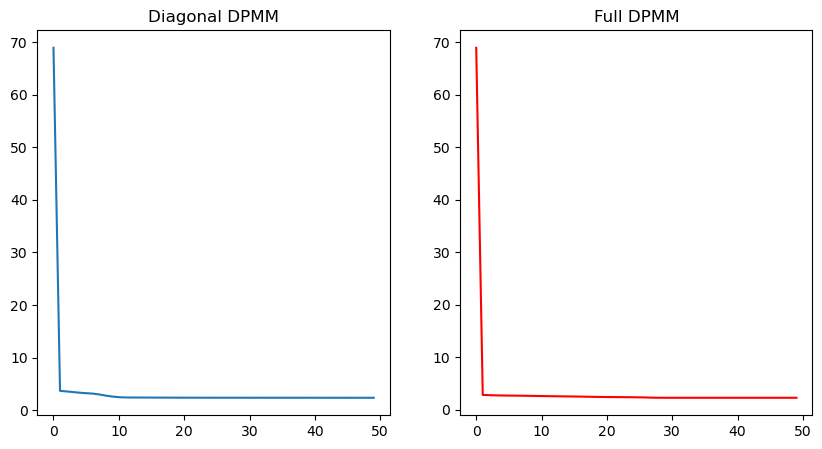

In [6]:
f, ax_list = plt.subplots(1,2, figsize=(10,5))
ax_list[0].plot(np.array(elbo_diag))
ax_list[0].set_title('Diagonal DPMM')
ax_list[1].plot(np.array(elbo_full), 'r')
ax_list[1].set_title('Full DPMM')
plt.show()

In [8]:
my_DPMM_diag.get_expected_params()

(tensor([0.2417, 0.2402, 0.2544, 0.0156, 0.1792, 0.0246, 0.0041, 0.0037, 0.0034,
         0.0031, 0.0028, 0.0025, 0.0023, 0.0021, 0.0019, 0.0017, 0.0015, 0.0014,
         0.0013, 0.0012]),
 tensor([[-7.9745e+00, -7.8376e+00],
         [ 7.7242e+00,  7.8724e+00],
         [ 1.3369e+00,  1.7257e+00],
         [-3.5882e-02,  4.9923e-01],
         [-6.3898e-01,  1.1377e+00],
         [-1.2832e+00,  1.1491e-01],
         [-1.5577e-03,  2.9418e-02],
         [-1.3834e-03,  2.6143e-02],
         [-1.2314e-03,  2.3283e-02],
         [-1.0981e-03,  2.0774e-02],
         [-9.8075e-04,  1.8563e-02],
         [-8.7715e-04,  1.6610e-02],
         [-7.8542e-04,  1.4879e-02],
         [-7.0399e-04,  1.3342e-02],
         [-6.3157e-04,  1.1974e-02],
         [-5.6705e-04,  1.0754e-02],
         [-5.0946e-04,  9.6644e-03],
         [-4.5801e-04,  8.6906e-03],
         [-4.1196e-04,  7.8189e-03],
         [-3.7073e-04,  7.0378e-03]]),
 tensor([[[2.2610, 0.0000],
          [0.0000, 2.0452]],
 
         [

In [19]:
new_x = [[20,-20], [-20,20],[30,30],[0,-10], [-10,0]]
new_x = th.tensor(new_x)


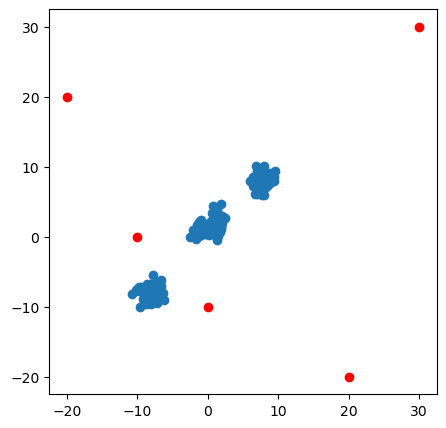

In [20]:
plt.scatter(x[:,0],x[:,1])
plt.scatter(new_x[:,0],new_x[:,1], c='r')


In [51]:
my_DPMM_diag.get_expected_log_likelihood(x[:10])

tensor([[-4.1721],
        [-4.9030],
        [-4.0656],
        [-4.2482],
        [-4.6753],
        [-4.0342],
        [-4.4969],
        [-4.4000],
        [-4.6612],
        [-4.6383]])

In [52]:
my_DPMM_diag.get_expected_log_likelihood(new_x)

tensor([[-213.1495],
        [-225.3464],
        [-248.9770],
        [ -19.2231],
        [ -19.9410]])

In [38]:
r, mu, s = my_DPMM_diag.get_expected_params()

In [39]:
r

tensor([0.2417, 0.2402, 0.2544, 0.0156, 0.1792, 0.0246, 0.0041, 0.0037, 0.0034,
        0.0031, 0.0028, 0.0025, 0.0023, 0.0021, 0.0019, 0.0017, 0.0015, 0.0014,
        0.0013, 0.0012])

In [41]:
th.sum(r*a, -1)

tensor([-128.8643, -173.6775, -131.7127, -156.8982, -161.5917, -135.3709,
        -161.1839, -142.7767, -163.0789, -175.3597])

In [42]:
th.sum(r*b, -1)

tensor([ -676.0161,  -692.4992, -1451.8044,   -86.3802,  -137.6952])

In [44]:
b[-2]

tensor([ -17.8031,  -91.4441,  -59.9431, -185.6371, -171.0152, -257.8879,
        -151.8894, -151.7052, -151.5457, -151.4068, -151.2852, -151.1785,
        -151.0844, -151.0011, -150.9273, -150.8618, -150.8035, -150.7514,
        -150.7051, -150.6636])

In [45]:
r

tensor([0.2417, 0.2402, 0.2544, 0.0156, 0.1792, 0.0246, 0.0041, 0.0037, 0.0034,
        0.0031, 0.0028, 0.0025, 0.0023, 0.0021, 0.0019, 0.0017, 0.0015, 0.0014,
        0.0013, 0.0012])

In [46]:
a[0]

tensor([  -2.7520, -120.5331, -205.8545, -227.9970, -181.9457, -198.3382,
        -178.2597, -178.0252, -177.8221, -177.6453, -177.4907, -177.3548,
        -177.2350, -177.1290, -177.0351, -176.9517, -176.8775, -176.8113,
        -176.7522, -176.6994])

In [48]:
(th.exp(a[0])*r).sum().log()

tensor(-4.1721)

In [49]:
(th.exp(b[-2])*r).sum().log()

tensor(-19.2231)

In [73]:
ppx, ppy = np.meshgrid(np.arange(-20,20,0.1), np.arange(-20,20,0.01))

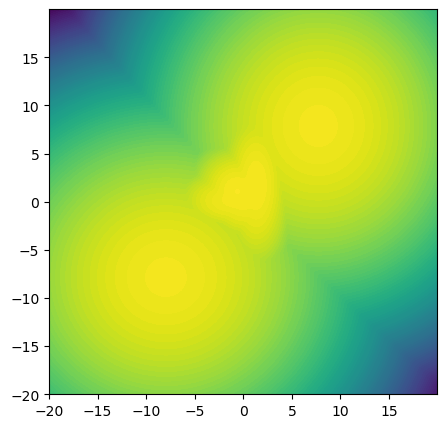

In [74]:
ll = my_DPMM_diag.get_expected_log_likelihood(th.stack([th.tensor(ppx.reshape(-1)), th.tensor(ppy.reshape(-1))]).T)
plt.contourf(ppx, ppy, ll.numpy().reshape(*ppx.shape), levels=100)

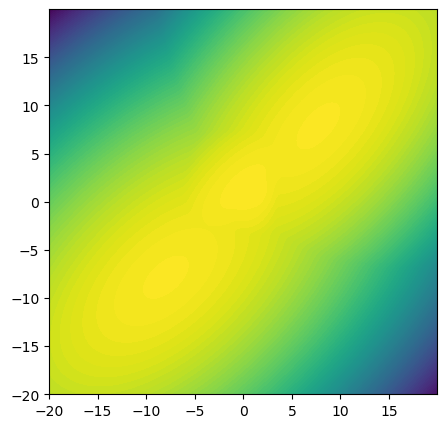

In [75]:
ll = my_DPMM_full.get_expected_log_likelihood(th.stack([th.tensor(ppx.reshape(-1)), th.tensor(ppy.reshape(-1))]).T)
plt.contourf(ppx, ppy, ll.numpy().reshape(*ppx.shape), levels=100)